Flipped corruption (p=0.3): Synchronous steps = 3, Asynchronous steps = 2
Cropped corruption: Synchronous steps = 4, Asynchronous steps = 4


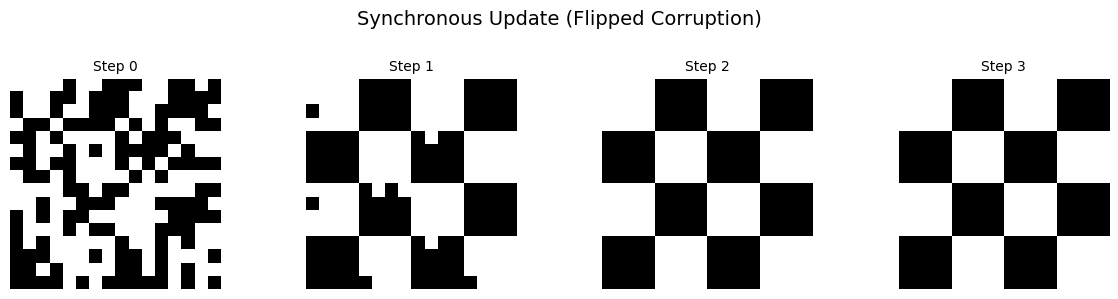

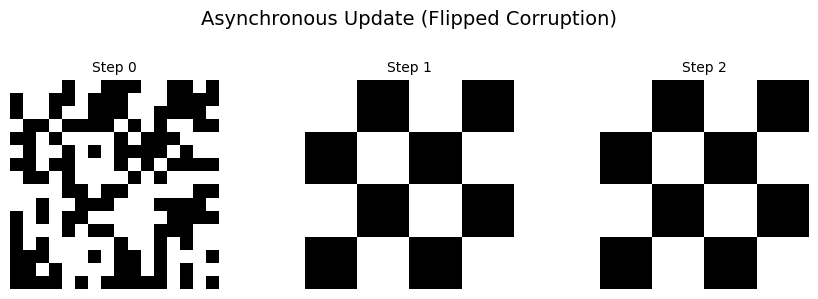

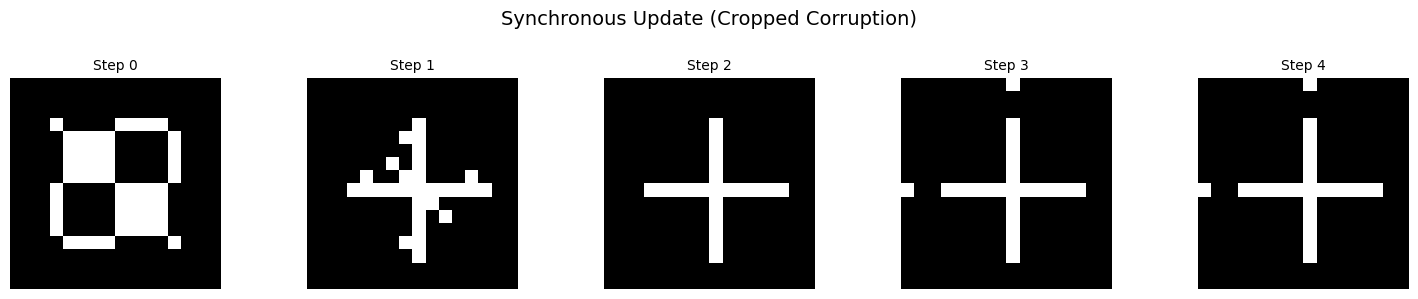

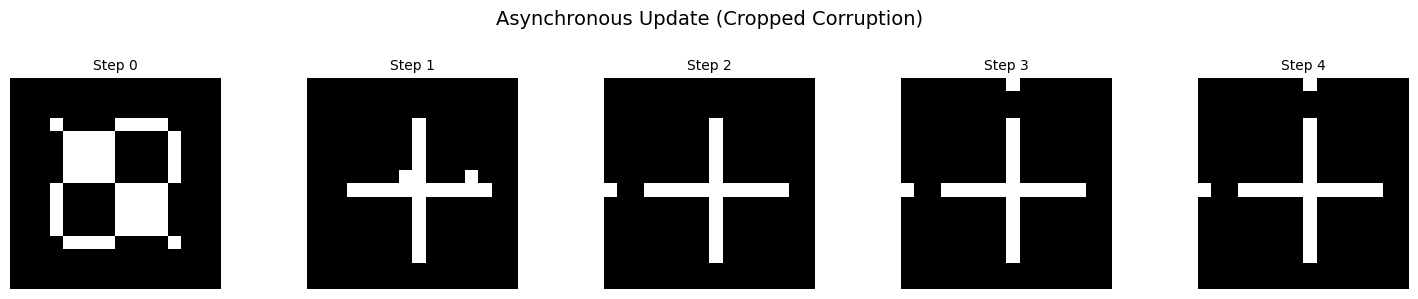

Saved midway synchronous flip state to 'midway_sync_flip.pbm'
Saved midway asynchronous flip state to 'midway_async_flip.pbm'
Saved midway synchronous crop state to 'midway_sync_crop.pbm'
Saved midway asynchronous crop state to 'midway_async_crop.pbm'


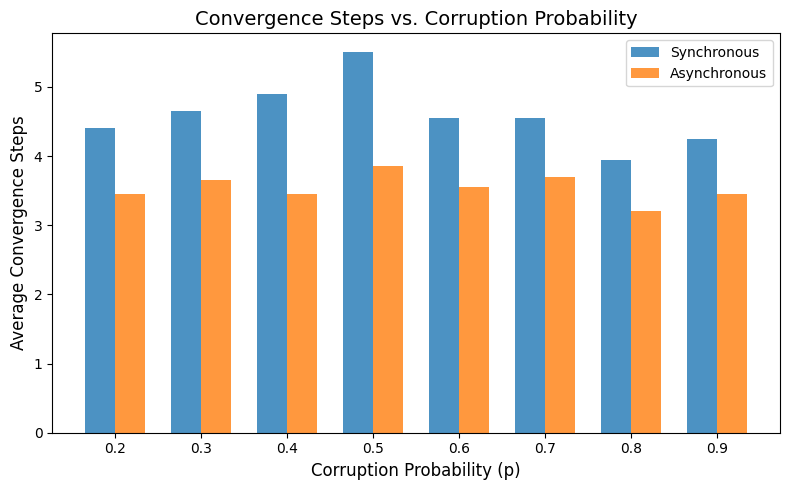

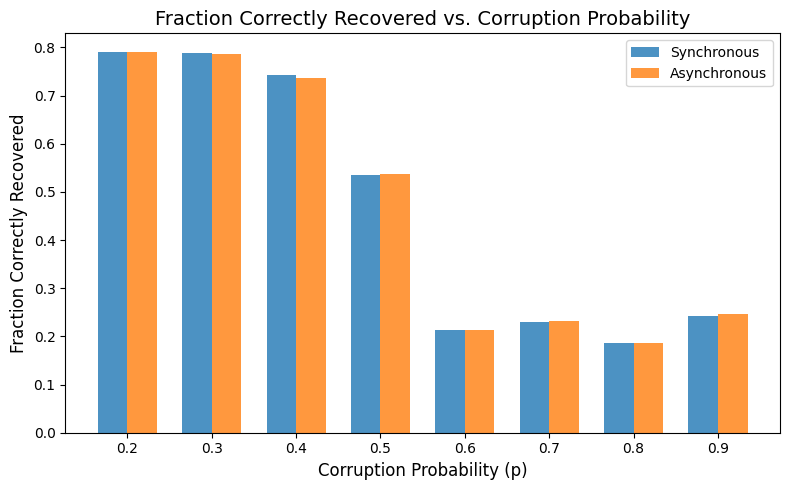

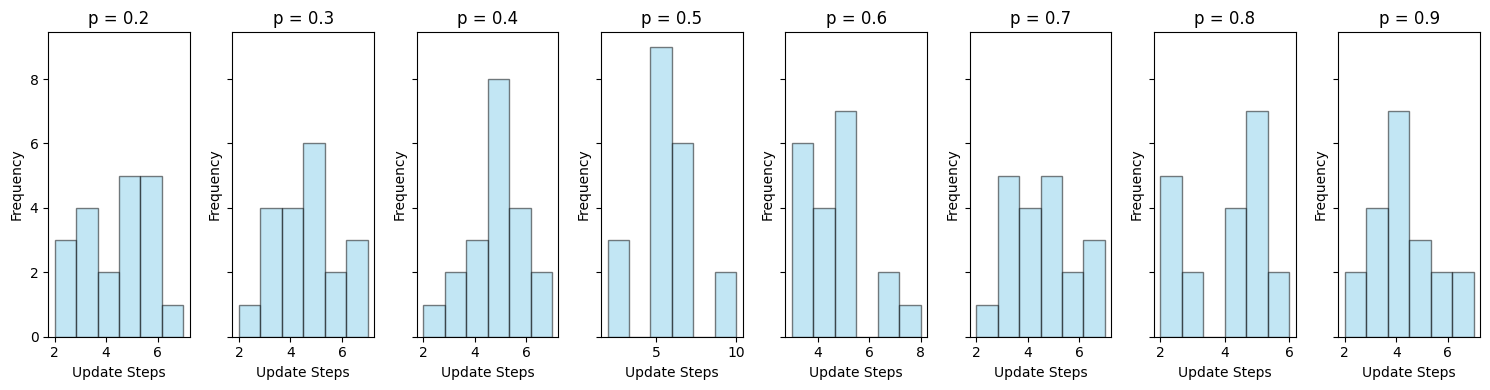

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt

def readfile(filename):
    with open(filename,'r') as f:
        lines=f.readlines()
    lines=[l.strip() for l in lines if not l.startswith('#')]
    assert lines[0] =='P1'
    width, height=map(int, lines[1].split())
    data=np.array([int(b) for line in lines[2:] for b in line.split()])
    return data.reshape((height, width))

def conv(mem):
    return 2*mem-1

# PROBLEM STATEMENT 1 Hopfield Network Training using Hebbian Rule
def trainingnet(memories):
    n=memories[0].size
    W=np.zeros((n, n))
    for mem in memories:
        vec=mem.flatten()
        W+= np.outer(vec, vec)     #Hebbian Learning Rule
    W/=len(memories)
    np.fill_diagonal(W,0)
    return W

def bitflip(mem,p):     #Bit flip corruption
    corrupt =np.random.rand(*mem.shape) < p
    corrupted_mem=np.copy(mem)
    corrupted_mem[corrupt] *= -1
    return corrupted_mem

def cropping(mem, bbox_color):     #Bounding box cropping
    cropped = np.full(mem.shape, -1 if bbox_color == "black" else 1)
    cropped[3:13, 3:13] = mem[3:13, 3:13]
    return cropped

def syncupdate(state,W):    #Synchronous Update
    h, w=state.shape
    flat=state.flatten()
    updated= np.sign(W @ flat)
    updated[updated==0] = 1
    return updated.reshape(h, w)

def asyncupdate(state,W):    #Asynchronous Update
    h, w=state.shape
    flat=state.flatten()
    indices=np.arange(flat.size)
    np.random.shuffle(indices)       #Random Shuffle
    for i in indices:
        flat[i]=1 if np.dot(W[i],flat) >= 0 else -1
    return flat.reshape(h, w)

def runconv(initial, W,updating):    #Run until we reach convergence
    prev_state=None
    state=initial
    steps=0
    hist =[initial.copy()]
    while not np.array_equal(state,prev_state):
        prev_state=state.copy()
        state =updating(state, W)
        steps+= 1
        hist.append(state.copy())
    return state, steps, hist

# UTILITY FUNCTIONS FOR PLOTTING THE CURVES
def plotseq(hist,title):  #Sequence Plotting
    n=len(hist)
    fig, axes=plt.subplots(1,n,figsize=(n * 3, 3),squeeze=False)
    for i, state in enumerate(hist):
        ax = axes[0, i]
        ax.imshow(state,cmap='gray',interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Step {i}", fontsize=10)
        for spine in ax.spines.values():
            spine.set_visible(False)
    fig.suptitle(title,fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def plothist(stepcnt,pval):  #Histogram Plotting
    fig,axes=plt.subplots(1,len(pval),figsize=(15, 4),sharey=True)
    for ax, p in zip(axes,pval):
        ax.hist(stepcnt[p],bins=6,alpha=0.5,edgecolor='black',color='skyblue')
        ax.set_title(f'p = {p}')
        ax.set_xlabel("Update Steps")
        ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def fillmemory(files):
    memories=[conv(readfile(f)) for f in files[:10]]
    return memories

def plotconvsteps(pval,syncsteps,asyncsteps):  #Convergence Steps Plotting
    plt.figure(figsize=(8,5))
    w=0.35
    indices = np.arange(len(pval))
    plt.bar(indices,syncsteps,w,label='Synchronous',alpha=0.8)
    plt.bar(indices + w,asyncsteps,w,label='Asynchronous',alpha=0.8)
    plt.xlabel("Corruption Probability (p)",fontsize=12)
    plt.ylabel("Average Convergence Steps",fontsize=12)
    plt.xticks(indices + w/2,[f"{p:.1f}" for p in pval],fontsize=10)
    plt.legend(fontsize=10)
    plt.title("Convergence Steps vs. Corruption Probability",fontsize=14)
    plt.tight_layout()
    plt.show()

def plotcorrect(pval,corrsync,corrasync):  #Correctly Recovered Plotting
    plt.figure(figsize=(8,5))
    w=0.35
    indices = np.arange(len(pval))
    plt.bar(indices, corrsync,w,label='Synchronous',alpha=0.8)
    plt.bar(indices + w, corrasync,w,label='Asynchronous',alpha=0.8)
    plt.xlabel("Corruption Probability (p)",fontsize=12)
    plt.ylabel("Fraction Correctly Recovered",fontsize=12)
    plt.xticks(indices + w/2,[f"{p:.1f}" for p in pval],fontsize=10)
    plt.legend(fontsize=10)
    plt.title("Fraction Correctly Recovered vs. Corruption Probability",fontsize=14)
    plt.tight_layout()
    plt.show()

# Saving the state of the Hopfield Network onto a PBM file midway during the updates as in PROBLEM STATEMENT 1
def savepbm(state,filename):
    # Convert from -1/1 to 0/1 for image reconstruction
    state_01=((state+1)/2).astype(int)
    h, w=state_01.shape
    with open(filename,'w') as f:
        f.write('P1\n')
        f.write(f'{w} {h}\n')
        for row in state_01:
            f.write(' '.join(str(val) for val in row)+ '\n')


# DRIVER CODE
def main():
    files=sorted(glob.glob('pattern_*.pbm'))
    memories=fillmemory(files)
    W=trainingnet(memories)

    # PROBLEM STATEMENT 2
    p=0.3
    memidx = np.random.randint(len(memories))
    orig=memories[memidx]
    bitflippy=bitflip(orig, p)
    croppy=cropping(orig, "black")

    finsyncflippy, syncstepflippy, histsyncflip = runconv(bitflippy, W, syncupdate)    #Bit flipped with synchronous update
    finasyncflippy, asyncstepflippy, histasyncflip = runconv(bitflippy, W, asyncupdate) #Bit flipped with asynchronous update
    finsynccroppy, syncstepcroppy, histsynccrop = runconv(croppy, W, syncupdate)   #Cropped with synchronous update
    finasynccroppy, asyncstepcroppy, histasynccrop = runconv(croppy, W, asyncupdate) #Cropped with asynchronous update

    print(f"Flipped corruption (p={p}): Synchronous steps = {syncstepflippy}, Asynchronous steps = {asyncstepflippy}")
    print(f"Cropped corruption: Synchronous steps = {syncstepcroppy}, Asynchronous steps = {asyncstepcroppy}")

    #Visualisations
    plotseq(histsyncflip, "Synchronous Update (Flipped Corruption)")
    plotseq(histasyncflip, "Asynchronous Update (Flipped Corruption)")
    plotseq(histsynccrop, "Synchronous Update (Cropped Corruption)")
    plotseq(histasynccrop, "Asynchronous Update (Cropped Corruption)")

    #Saving Midway updates to PBM files
    if histsyncflip:
        midpoint = len(histsyncflip)//2
        savepbm(histsyncflip[midpoint], 'midway_sync_flip.pbm')
        print("Saved midway synchronous flip state to 'midway_sync_flip.pbm'")
    if histasyncflip:
        midpoint = len(histasyncflip)//2
        savepbm(histasyncflip[midpoint], 'midway_async_flip.pbm')
        print("Saved midway asynchronous flip state to 'midway_async_flip.pbm'")
    if histsynccrop:
        midpoint = len(histsynccrop)//2
        savepbm(histsynccrop[midpoint], 'midway_sync_crop.pbm')
        print("Saved midway synchronous crop state to 'midway_sync_crop.pbm'")
    if histasynccrop:
        midpoint = len(histasynccrop)//2
        savepbm(histasynccrop[midpoint], 'midway_async_crop.pbm')
        print("Saved midway asynchronous crop state to 'midway_async_crop.pbm'")

    # PROBLEM STATEMENT 3
    pval=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    paircntp=20

    syncstepcnt={p: [] for p in pval}
    asyncstepcnt={p: [] for p in pval}
    corrsync={p: [] for p in pval}
    corrasync={p: [] for p in pval}

    for p in pval:
      for _ in range(paircntp):
        memidx=np.random.randint(len(memories))
        orig=memories[memidx]
        corrupted=bitflip(orig, p)
        finsync, stepsync, _= runconv(corrupted, W, syncupdate)
        finasync, stepasync, _= runconv(corrupted, W, asyncupdate)
        syncstepcnt[p].append(stepsync)
        asyncstepcnt[p].append(stepasync)
        corrsync[p].append(np.mean(finsync==orig))
        corrasync[p].append(np.mean(finasync==orig))

    avgsyncsteps=[np.mean(syncstepcnt[p]) for p in pval]
    avgasyncsteps=[np.mean(asyncstepcnt[p]) for p in pval]
    avgcorrsync=[np.mean(corrsync[p]) for p in pval]
    avgcorrasync=[np.mean(corrasync[p]) for p in pval]

    plotconvsteps(pval,avgsyncsteps,avgasyncsteps)
    plotcorrect(pval,avgcorrsync,avgcorrasync)
    plothist(syncstepcnt,pval)

if __name__=="__main__":
    main()